# **Capitulo 5 – Time Series**

# Setup

Como hicimos en NoteBooks anteriores, vamos a definir los tamaños de fuente por defecto para que las figuras queden más bonitas:

In [11]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Y vamos a crear la carpeta `images/time_series` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "time_series"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# ¿Qué es la tendencia? #

El componente **tendencia** de una serie temporal representa un cambio persistente a largo plazo en la media de la serie. La tendencia es la parte de movimiento más lento de una serie, la parte que representa la mayor escala temporal de importancia. En una serie temporal de ventas de productos, una tendencia creciente podría ser el efecto de una expansión del mercado a medida que más gente conoce el producto año tras año.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZdS4ZoJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Patrones de tendencia en cuatro series temporales.</center></figcaption>
</figure>

En este NoteBook, nos centraremos en las tendencias de la media. Sin embargo, en términos más generales, cualquier cambio persistente y lento en una serie podría constituir una tendencia; por ejemplo, las series temporales suelen tener tendencias en su varianza.

# Gráficos de medias móviles

Para ver qué tipo de tendencia puede tener una serie temporal, podemos utilizar un **gráfico de medias móviles**. Para calcular una media móvil de una serie temporal, calculamos la media de los valores dentro de una ventana deslizante de cierta anchura definida. Cada punto del gráfico representa la media de todos los valores de la serie que caen dentro de la ventana a cada lado. La idea es suavizar las fluctuaciones a corto plazo de la serie para que sólo se mantengan los cambios a largo plazo.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/EZOXiPs.gif" width=800, alt="Gráfico animado que muestra una curva ondulada que aumenta lentamente con una línea de media móvil que se desarrolla de izquierda a derecha dentro de una ventana de 12 puntos (en rojo).">
<figcaption style="textalign: center; font-style: italic"><center>Un gráfico de media móvil que ilustra una tendencia lineal. Cada punto de la curva (azul) es la media de los puntos (rojo) dentro de una ventana de tamaño 12.
</center></figcaption>
</figura>

Observe cómo la serie *Mauna Loa* anterior tiene un movimiento ascendente y descendente que se repite año tras año: un cambio a corto plazo, *estacional*. Para que un cambio forme parte de la tendencia, debe producirse durante un periodo más largo que cualquier cambio estacional. Por lo tanto, para visualizar una tendencia, se toma la media de un periodo más largo que cualquier periodo estacional de la serie. Para la serie *Mauna Loa*, elegimos una ventana de tamaño 12 para suavizar la estación dentro de cada año.

# Engineering Trend #

Una vez que hemos identificado la forma de la tendencia, podemos intentar modelarla utilizando una función de paso de tiempo. Ya hemos visto cómo utilizando el dummy de tiempo que por sí mismo modelará una tendencia lineal:

```
objetivo = a * tiempo + b
```

Podemos ajustar muchos otros tipos de tendencia mediante transformaciones de la variable dummy tiempo. Si la tendencia parece ser cuadrática (una parábola), sólo tenemos que añadir el cuadrado del tiempo dummy al conjunto de características, lo que nos da:
```
objetivo = a * tiempo ** 2 + b * tiempo + c
```
La regresión lineal aprenderá los coeficientes "a", "b" y "c".

Las curvas de tendencia en la siguiente figura se ajustaron utilizando este tipo de características y `LinearRegression` de scikit-learn:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/KFYlgGm.png" width=*00, alt="Arriba, Coches vendidos en Quebec: un gráfico ondulado que aumenta gradualmente de 1960-01 a 1968-12 con una línea de tendencia lineal superpuesta. Abajo, Producción de plásticos en Australia: un gráfico ondulado con una línea de tendencia cuadrática cóncava ascendente superpuesta.">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top:</strong> Serie con una tendencia lineal. <strong>Abajo:</strong> Serie con una tendencia cuadrática.
</center></figcaption>
</figura>

Si no has visto el truco antes, puede que no te hayas dado cuenta de que la regresión lineal puede ajustar curvas que no sean líneas. La idea es que si puedes proporcionar curvas de la forma adecuada como características, entonces la regresión lineal puede aprender a combinarlas de la forma que mejor se ajuste al objetivo.

# Ejemplo - Tráfico en túneles

En este ejemplo crearemos un modelo de tendencia para el conjunto de datos *Túnel de Tráfico*.

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")

data_dir = Path("data") #utilizo path  para agregar la carpeta data
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Hagamos un gráfico de medias móviles para ver qué tipo de tendencia tiene esta serie. Como esta serie tiene observaciones diarias, vamos a elegir una ventana de 365 días para suavizar cualquier cambio a corto plazo dentro del año.

Para crear una media móvil, utilice primero el método `rolling` para iniciar un cálculo de ventana. A continuación, utilice el método de la media para calcular la media a lo largo de la ventana. Como podemos ver, la tendencia de *Tunnel Traffic* parece ser lineal.

<Figure size 1200x1000 with 0 Axes>

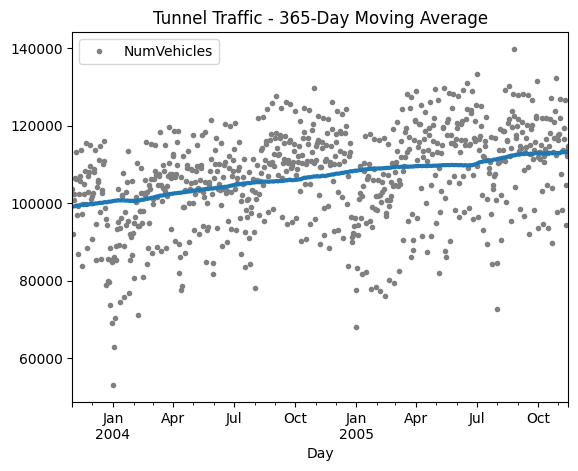

In [4]:
plt.figure(figsize=(12, 10))

moving_average = tunnel.rolling(
    window=365,   #hay que buscar un numero buen para que la media movil sea lo mas parecida a una recta de tendencia (si lo hicieramos mas pequeña la ventana, tendriamso muchas más fluctuaciones.)      
    center=True,      # sitúa la media en el centro de la ventana
    min_periods=183,  # elija aproximadamente la mitad del tamaño de la ventana
).mean()              

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

# la linea no es la tendencia, si no la media movil 


En el NoteBook anterior, diseñamos nuestro dummy de tiempo en Pandas directamente. A partir de ahora, sin embargo, utilizaremos una función de la librería `statsmodels` llamada `DeterministicProcess`. El uso de esta función nos ayudará a evitar algunos casos de fallo complicados que pueden surgir con las series temporales y la regresión lineal. El argumento `order` se refiere al orden polinómico: `1` para lineal, `2` para cuadrático, `3` para cúbico, etc.

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  
    constant=True,       # característica dummy para el sesgo (y_intercept)
    order=1,             # la variable ficticia del tiempo (tendencia)
    drop=True,           # elimine términos si es necesario para evitar colinealidad
)
# `in_sample` crea características para las fechas dadas en el argumento `index del modelo anterior
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


(Un *proceso determinista*, por cierto, es un término técnico para una serie temporal que no es aleatoria o que está completamente *determinada*, como lo están las series `const` y `trend`. Las características derivadas del índice temporal serán generalmente deterministas).

Creamos nuestro modelo de tendencia básicamente como antes, aunque observe la adición del argumento `fit_intercept=False`.

In [6]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]

# La intercepción es el mismo que el `const` característica de
# DeterministicProcess. LinearRegression se comporta mal con 
# características duplicadas, por lo que necesitamos estar seguros de excluirlos.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

La tendencia descubierta por nuestro modelo `LinearRegression` es casi idéntica a la gráfica de la media móvil, lo que sugiere que una tendencia lineal era la decisión correcta en este caso.

<Figure size 1200x1000 with 0 Axes>

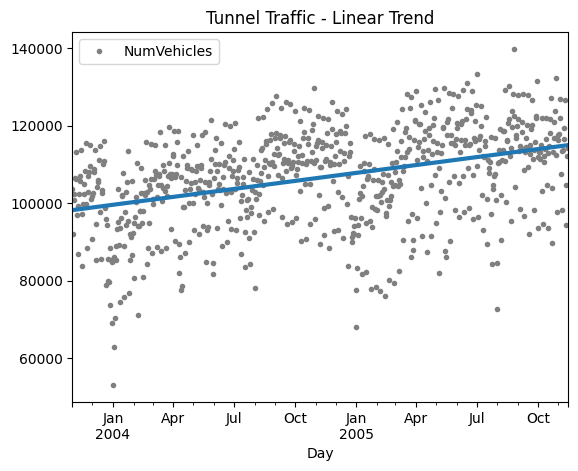

In [8]:
plt.figure(figsize=(12, 10))
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Para hacer una previsión, aplicamos nuestro modelo a las características "fuera de muestra". Por "fuera de muestra" se entienden los momentos fuera del periodo de observación de los datos de entrenamiento. Así es como podríamos hacer una previsión para 30 días:

In [9]:
X = dp.out_of_sample(steps=30)
# dp es deterministprocess, y le digo que incluya 30 dias adicionales

y_fore = pd.Series(model.predict(X), index=X.index)
# predecismo segun el modelo y esa q nueva que hemos aumentado.
y_fore.head()
# devuevle serie temporal con l fecha y la cantidad de coches que pasan en ese dia (habris que redondear)

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Vamos a trazar una parte de la serie para ver la tendencia prevista para los próximos 30 días:

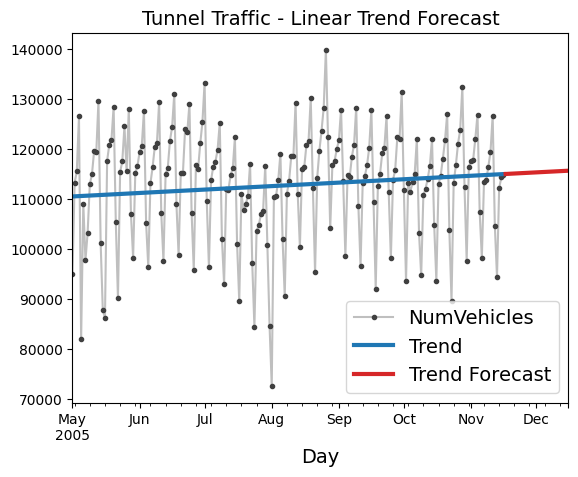

In [12]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

---

Los modelos de tendencias que hemos aprendido en este NoteBook resultan útiles por varias razones. Además de actuar como línea base o punto de partida para modelos más sofisticados, también podemos utilizarlos como componente de un "modelo híbrido" con algoritmos incapaces de aprender tendencias (como XGBoost y los bosques aleatorios)
